# Moving Averages CINGULATE region

### 1) Imports

In [1]:
import os
import glob
import sys

p = os.path.abspath('../')
if p not in sys.path:
    sys.path.append(p)

In [55]:
import moving_averages as ma
import colorado as cld
import dico_toolbox as dtx
from tqdm import tqdm

import pandas as pd
import numpy as np
from scipy.spatial import distance

import plotly.graph_objects as go
import pickle
import matplotlib.pyplot as plt

from soma import aims

from datasets import SkeletonDataset
import torch
from vae import *

from sklearn.cluster import KMeans, SpectralClustering, AffinityPropagation
from sklearn import metrics

import matplotlib.cm as cm

ModuleNotFoundError: No module named 'seaborn'

In [140]:
def closest_distance(centroid, df):
    """Returns closest point to centroid of a given cluster
    /!\ central_point is part of the defined set of points
    Args:
        IN: centroid: tuple of coordinates of centroid
            df: pandas.DataFrame with index corresponding to subjects and as many columns as coordinates
        OUT: central_point: subject ID corresponding to closest point to the centroid
    """
    # df must have as many columns as dimensions to consider
    distances = {}
    # Get distances to centroid for each point
    for sub in list(df.index):
        pos = [df.loc[sub][k] for k in range(1, len(df.columns)+1)]
        distances[sub] = distance.euclidean(pos, centroid)
    # Get closest point to centroid
    central_point = min(distances, key=distances.get)
    return central_point

In [4]:
path = '/neurospin/dico/data/deep_folding/current/crops/CINGULATE/mask/sulcus_based/2mm/centered_combined/hcp/Rcrops/'

### 2) Loading of subjects's distribution in the latent space
DataFrame is obtained during analysis of beta-VAE latent space (2 dimensions) for CINGULATE crops, according to the following steps:
- loading of trained model
- encoding of test controls and asymmetry benchmark subjects

In [5]:
if torch.cuda.is_available():
    device = "cuda:0"

In [6]:
model_dir = '/neurospin/dico/lguillon/midl_22/new_design/gridsearch/n_2_kl_2/'
model = VAE((1, 20, 40, 40), 2, depth=3)
model.load_state_dict(torch.load(model_dir + 'checkpoint.pt'))
model = model.to(device)

In [7]:
subject_dir = "/neurospin/dico/data/deep_folding/current/"
data_dir = "/neurospin/dico/data/deep_folding/current/crops/CINGULATE/mask/sulcus_based/2mm/centered_combined/hcp/"

train_list = pd.read_csv(os.path.join(subject_dir,
                         f"HCP_half_{1}bis.csv"), header=None,
                         usecols=[0], names=['subjects'])

train_list['subjects'] = train_list['subjects'].astype('str')

tmp = pd.read_pickle(os.path.join(data_dir, "Rskeleton.pkl")).T
#tmp = tmp.rename(columns={0:'subjects'})
tmp.index.astype('str')

tmp = tmp.merge(train_list, left_on = tmp.index, right_on='subjects', how='right')

filenames = list(train_list['subjects'])

subset = SkeletonDataset(dataframe=tmp, filenames=filenames)

In [8]:
dataloader = torch.utils.data.DataLoader(
              subset,
              batch_size=64,
              num_workers=8,
              shuffle=True)    

In [9]:
dico_set_loaders = {'data': dataloader}

root_dir = '/neurospin/dico/lguillon/midl_22/new_design/analysis/n_2_kl_2/'

weights = [1, 2]
class_weights = torch.FloatTensor(weights).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights, reduction='sum')
tester = ModelTester(model=model, dico_set_loaders=dico_set_loaders,
                     loss_func=criterion, kl_weight=2,
                     n_latent=2, depth=3, root_dir=root_dir)

In [10]:
results = tester.test()
encoded = {loader_name:[results[loader_name][k] for k in results[loader_name].keys()] for loader_name in dico_set_loaders.keys()}
df_encoded = pd.DataFrame()
df_encoded['latent'] = encoded['data']
X = np.array(list(df_encoded['latent']))
labels = list(results['data'].keys())

0.399704
For n_clusters = 2 The average silhouette_score with kmeans is : 0.399704


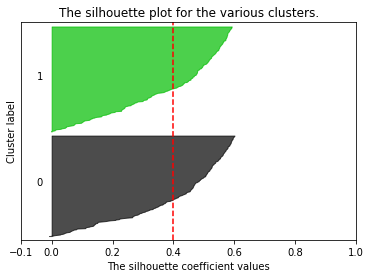

0.3357302
For n_clusters = 3 The average silhouette_score with kmeans is : 0.3357302


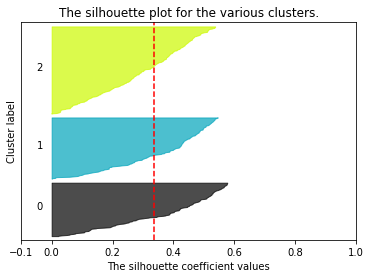

0.36729297
For n_clusters = 4 The average silhouette_score with kmeans is : 0.36729297


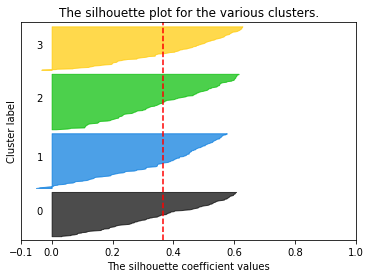

0.35345674
For n_clusters = 5 The average silhouette_score with kmeans is : 0.35345674


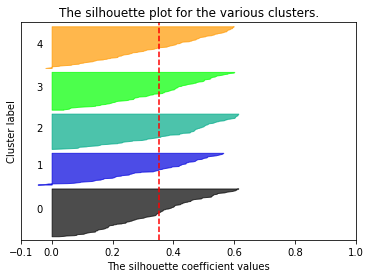

0.33955154
For n_clusters = 6 The average silhouette_score with kmeans is : 0.33955154


0.3270065
For n_clusters = 7 The average silhouette_score with kmeans is : 0.3270065


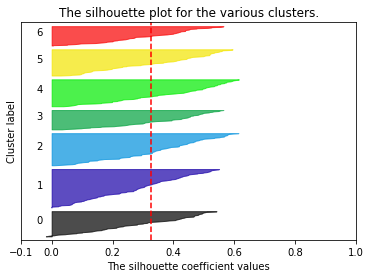

0.3368073
For n_clusters = 8 The average silhouette_score with kmeans is : 0.3368073


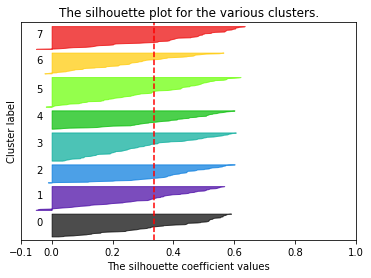

0.34915078
For n_clusters = 9 The average silhouette_score with kmeans is : 0.34915078


0.34676325
For n_clusters = 10 The average silhouette_score with kmeans is : 0.34676325


In [11]:
n_clusters_list = [2, 3, 4,5,6,7,8,9,10]

for n in n_clusters_list:
    cluster_labels= KMeans(n_clusters=n, random_state=0).fit_predict(X)
    print(str(metrics.silhouette_score(X, cluster_labels)))

    fig, ax1 = plt.subplots()
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n + 1) * 10])
    silhouette_avg = metrics.silhouette_score(X, cluster_labels)
    print("For n_clusters =", n, "The average silhouette_score with kmeans is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = metrics.silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    plt.show()

The best silhouette score is obtained with n_clusters = 2

In [26]:
kmeans = KMeans(n_clusters=2, random_state=0).fit(X)
cluster_labels = kmeans.labels_
clusters_centroids = kmeans.cluster_centers_
print(f"Average silhouette score: {metrics.silhouette_score(X, cluster_labels)}")


Average silhouette score: 0.3997040092945099


In [134]:
dstrb_sub = pd.DataFrame(X, index=labels, columns=[1, 2])
dstrb_sub['cluster_lab'] = cluster_labels

In [135]:
dstrb_sub.head()

1         2  cluster_lab
779370 -0.983108  0.650444            0
782157 -1.132291  1.812596            1
887373 -1.117753  3.157457            1
599671 -1.365171  1.205860            0
156334  0.239051  2.762050            1

In [136]:
clusters_centroids = kmeans.cluster_centers_
print(f"cluster's centroids coordinates: \n {clusters_centroids}")

cluster's centroids coordinates: 
 [[-2.3458006   1.1826161 ]
 [-0.85848826  2.2802181 ]]


In [141]:
central_1 = closest_distance(clusters_centroids[0], dstrb_sub.drop(['cluster_lab'], axis=1))
print(f"Closest subject to centroid of cluster 1 is {central_1}")
central_2 = closest_distance(clusters_centroids[1], dstrb_sub.drop(['cluster_lab'], axis=1))
print(f"Closest subject to centroid of cluster 2 is {central_2}")

Closest subject to centroid of cluster 1 is 667056
Closest subject to centroid of cluster 2 is 133827


In [27]:
arr = np.array([np.array([dstrb_sub[k][i] for k in dstrb_sub.columns[:2]]) for i in range(len(dstrb_sub))])

color_dict = {1: 'red', 0:'blue'}
fig, ax = plt.subplots()

for g in np.unique([dstrb_sub.cluster_lab]):
    ix = np.where(dstrb_sub.cluster_lab == g)
    x = [arr[ix][k][0] for k in range(len(ix[0]))]
    y = [arr[ix][k][1] for k in range(len(ix[0]))]
    if g =='benchmark':
        g_lab = 'benchmark asymmetry'
    else:
        g_lab=g
    ax.scatter(x, y, c = color_dict[g], label = g_lab)
    
ax.scatter(clusters_centroids[0][0], clusters_centroids[0][1], color='crimson', marker='X')
ax.scatter(clusters_centroids[1][0], clusters_centroids[1][1], color='navy', marker='X')
ax.scatter(dstrb_sub[0]['667056'], dstrb_sub[1]['667056'], color='forestgreen')
ax.scatter(dstrb_sub[0]['133827'], dstrb_sub[1]['133827'], color='forestgreen')

plt.xlabel(f'dimension 1', fontsize=14)
plt.ylabel(f'dimension 2', fontsize=14)
plt.show()

In [142]:
cluster1 = dstrb_sub[dstrb_sub.cluster_lab==0]
cluster2 = dstrb_sub[dstrb_sub.cluster_lab==1]
assert(len(np.unique(list(cluster1.cluster_lab)))==1)
assert(len(np.unique(list(cluster2.cluster_lab)))==1)

### Creation of buckets dictionnary

In [41]:
def create_bucket(vol):
    arr = np.asarray(vol)

    # Threshold and "binarize"
    arr[np.where(arr > 1)]=1
    # Writes volume
    temp_dir = '/tmp/'
    threshold_filename = f'{temp_dir}/temp_threshold.nii.gz'
    aims.write(vol, threshold_filename)
    # Save to bucket file
    bucket_filename = f"{temp_dir}/temp_bucket.bck"
    cmd = f"AimsFileConvert -c Bucket -t VOID -e 1 -i {threshold_filename} -o {bucket_filename}"
    os.system(cmd)
    # Displays bucket file
    bucket, bucket_raw, dxyz, rot, tr = ma.load_bucket(bucket_filename)
    m = dtx.convert.bucket_to_mesh(bucket)
    cmd = f"rm {threshold_filename} {threshold_filename+'.minf'} {bucket_filename} {bucket_filename+'.minf'}"
    os.system(cmd)
    
    return bucket, m

In [46]:
bucket_path = '/neurospin/dico/data/deep_folding/current/crops/CINGULATE/mask/sulcus_based/2mm/centered_combined/hcp/Rcrops/'
suffix_path = '_normalized.nii.gz'
buckets = {}
for sub in tqdm(list(labels)):
    bucket = aims.read(os.path.join(bucket_path, str(sub) + suffix_path))
    bucket, m = create_bucket(bucket)
    bucket = np.asarray(bucket)
    buckets[sub] = bucket

100%|██████████| 550/550 [13:53<00:00,  1.52s/it]


In [143]:
subjects_c1 = cluster1.index
subjects_c2 = cluster2.index

buckets_c1 = {k: v for k,v in buckets.items() if k in list(subjects_c1)}
buckets_c2 = {k: v for k,v in buckets.items() if k in list(subjects_c2)}

#### Alignement of the subjects to respective central subject

In [144]:
aligned_buckets_C1, aligned_rot_C1, aligned_transl_C1 = ma.align_buckets_by_ICP_batch(buckets_c1, central_1)
aligned_buckets_C2, aligned_rot_C2, aligned_transl_C2 = ma.align_buckets_by_ICP_batch(buckets_c2, central_2)

>>> INFO moving_averages.transform - using 45 cores out of 48
Aligning buckets to 667056: 100%|██████████| 281/281 [00:04<00:00, 70.05it/s] 
>>> INFO moving_averages.transform - using 45 cores out of 48
Aligning buckets to 133827: 100%|██████████| 269/269 [00:04<00:00, 55.89it/s]


(array([ 2., 10., 18., 39., 56., 60., 50., 32., 11.,  3.]),
 array([-4.351916  , -3.9694564 , -3.5869973 , -3.2045379 , -2.8220787 ,
        -2.4396193 , -2.05716   , -1.6747007 , -1.2922413 , -0.90978205,
        -0.52732277], dtype=float32),
 <BarContainer object of 10 artists>)

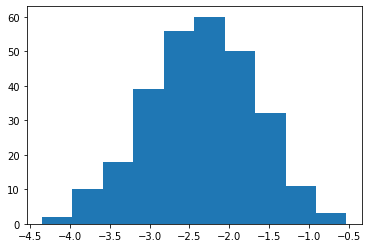

In [191]:
plt.hist(cluster1[1])

In [265]:
plt.hist(cluster2[-2.05716])

KeyError: -2.05716

In [226]:
np.mean(list(cluster1[1]))

-2.348211644595204

In [266]:
SPAM_centers_c1 = [-2.05716]
SPAM_vols_c1, shift1 = ma.calc_MA_volumes_batch(SPAM_centers_c1, aligned_buckets_C1, cluster1, axis_n=1, FWHM=1)

Calculating moving averages: 100%|██████████| 1/1 [00:00<00:00,  6.77it/s]


In [263]:
SPAM_meshes = {}

for k, volume in tqdm(list(SPAM_vols_c1.items())[:]):
    SPAM_meshes[k]=dtx.convert.volume_to_mesh(
                    vol=volume, gblur_sigma=0.8)
    
shifted_SPAM_meshes = {}
for dist, mesh in SPAM_meshes.items():
    shifted_SPAM_meshes[str(dist)]=cld.aims_tools.shift_aims_mesh(mesh, dist)

100%|██████████| 1/1 [00:00<00:00,  3.48it/s]


In [249]:
SPAM_centers_c2 = [0]
SPAM_vols_c2, shift2 = ma.calc_MA_volumes_batch(SPAM_centers_c2, aligned_buckets_C2, cluster2, axis_n=1, FWHM=1)

Calculating moving averages: 100%|██████████| 1/1 [00:00<00:00,  3.32it/s]


In [250]:
SPAM_meshes2 = {}

for k, volume in tqdm(list(SPAM_vols_c2.items())[:]):
    SPAM_meshes2[k]=dtx.convert.volume_to_mesh(
                    vol=volume, gblur_sigma=0.8)
    
shifted_SPAM_meshes2 = {}
for dist, mesh in SPAM_meshes2.items():
    shifted_SPAM_meshes2[str(dist)]=cld.aims_tools.shift_aims_mesh(mesh, dist)

100%|██████████| 1/1 [00:00<00:00,  3.65it/s]


#### Visualization of average crops of both clusters

In [209]:
fig = cld.draw(shifted_SPAM_meshes)
ma.plot.brochette_layout(fig, "subjects meshes")

In [88]:
fig = cld.draw(shifted_SPAM_meshes2)
ma.plot.brochette_layout(fig, "subjects meshes")

In [264]:
for x, mesh in tqdm(shifted_SPAM_meshes.items()):
    aims.write(mesh, f"MA_{x}_2cluster22.mesh")#### Saving of average crops

100%|██████████| 1/1 [00:00<00:00, 56.51it/s]


In [252]:

for x, mesh in tqdm(shifted_SPAM_meshes2.items()):
    aims.write(mesh, f"MA_{x}_2cluster2.mesh")

100%|██████████| 1/1 [00:00<00:00, 26.18it/s]


### 5) 2 clusters analysis

#### Loading of subjects of the two clusters

In [ ]:
tsne_subjects = pd.read_csv('tsne_asym_bench_sc.csv', index_col="id_sub").drop(columns={'Unnamed: 0'})
subjects_tsne = tsne_subjects.index
tsne_subjects = tsne_subjects.rename(columns={'tsne: 0': 0, 'tsne: 1': 1})
tsne_subjects.head()

We can use labels if we have them (in the case where we use benchmark subjects vs controls for example):

In [ ]:
color_dict = {'normal_test': 'blue', 'benchmark': 'magenta'}

arr = np.array([np.array([tsne_subjects[k][i] for k in tsne_subjects.columns[:2]]) for i in tsne_subjects.index])

fig, ax = plt.subplots()
ax = fig.add_subplot(111)
for g in np.unique([tsne_subjects.label]):
    ix = np.where(tsne_subjects.label == g)
    x = [arr[ix][k][0] for k in range(len(ix[0]))]
    y = [arr[ix][k][1] for k in range(len(ix[0]))]
    if g =='benchmark':
        g_lab = 'benchmark asymmetry'
    else:
        g_lab=g
    ax.scatter(x, y, c = color_dict[g], label = g_lab)

plt.xlabel(f'1st most important feature: {tsne_subjects.columns[0]}', fontsize=14)
plt.ylabel(f'2nd most important feature: {tsne_subjects.columns[1]}', fontsize=14)
plt.show()

We can also imagine a case where we don't have any labels but two clusters and apply a kmeans algorithm:

In [ ]:
from sklearn.cluster import KMeans

X = np.array([np.array([tsne_subjects[k][i] for k in tsne_subjects.columns[:2]]) for i in tsne_subjects.index])

kmeans = KMeans(n_clusters=2, random_state=0).fit(X)

labels = kmeans.labels_
tsne_subjects['kmeans_label'] = labels
clusters_centroids = kmeans.cluster_centers_
print(f"cluster's centroids coordinates: \n {clusters_centroids}")

In [ ]:
color_dict = {1: 'blue', 0: 'magenta'}

arr = np.array([np.array([tsne_subjects[k][i] for k in tsne_subjects.columns[:2]]) for i in tsne_subjects.index])

fig, ax = plt.subplots()
ax = fig.add_subplot(111)

for g in np.unique(kmeans.labels_):
    ix = np.where(kmeans.labels_ == g)
    x = [arr[ix][k][0] for k in range(len(ix[0]))]
    y = [arr[ix][k][1] for k in range(len(ix[0]))]
    if g =='benchmark':
        g_lab = 'benchmark asymmetry'
    else:
        g_lab=g
    ax.scatter(x, y, c = color_dict[g], label = g_lab)

ax.scatter(clusters_centroids[0][0], clusters_centroids[0][1], color='crimson', marker='X')
ax.scatter(clusters_centroids[1][0], clusters_centroids[1][1], color='navy', marker='X')
ax.scatter(tsne_subjects[0][116726], tsne_subjects[1][116726], color='forestgreen')
ax.scatter(tsne_subjects[0][163836], tsne_subjects[1][163836], color='forestgreen')


plt.xlabel(f'{tsne_subjects.columns[0]}', fontsize=14)
plt.ylabel(f'{tsne_subjects.columns[1]}', fontsize=14)
plt.show()

#### Central subjects for both clusters:

In [ ]:
central_1 = closest_distance(clusters_centroids[0], tsne_subjects.drop(['label', 'kmeans_label'], axis=1))
print(f"Closest subject to centroid of cluster 1 is {central_1}")
central_2 = closest_distance(clusters_centroids[1], tsne_subjects.drop(['label', 'kmeans_label'], axis=1))
print(f"Closest subject to centroid of cluster 2 is {central_2}")

We create sub-dataframes based on labels

In [ ]:
cluster1 = tsne_subjects[tsne_subjects.kmeans_label==0]
cluster2 = tsne_subjects[tsne_subjects.kmeans_label==1]
assert(len(np.unique(list(cluster1.kmeans_label)))==1)
assert(len(np.unique(list(cluster2.kmeans_label)))==1)

#### Creation of buckets dictionnary

In [ ]:
subjects_c1 = cluster1.index
subjects_c2 = cluster2.index

buckets_c1 = {k: v for k,v in buckets.items() if k in list(subjects_c1)}
buckets_c2 = {k: v for k,v in buckets.items() if k in list(subjects_c2)}

#### Alignement of the subjects to respective central subject

In [ ]:
aligned_buckets_C1, aligned_rot_C1, aligned_transl_C1 = ma.align_buckets_by_ICP_batch(buckets_c1, central_1, cores=2)
aligned_buckets_C2, aligned_rot_C2, aligned_transl_C2 = ma.align_buckets_by_ICP_batch(buckets_c2, central_2, cores=2)

In [ ]:
sns.displot(cluster1, x=0)

In [ ]:
sns.displot(cluster2, x=0)

In [ ]:
SPAM_centers_c1 = [0]
SPAM_vols_c1 = ma.calc_MA_volumes_batch(SPAM_centers_c1, aligned_buckets_C1, cluster1, axis_n=0, FWHM=1)

In [ ]:
SPAM_centers_c2 = [4.5]
SPAM_vols_c2 = ma.calc_MA_volumes_batch(SPAM_centers_c2, aligned_buckets_C2, cluster2, axis_n=0, FWHM=1)

In [ ]:
SPAM_meshes = {}

for k, volume in tqdm(list(SPAM_vols_c1.items())[:]+list(SPAM_vols_c2.items())[:]):
    SPAM_meshes[k]=cld.aims_tools.volume_to_mesh(
                    volume=volume, smoothingFactor=1.4,
                    aimsThreshold="90%")
    
shifted_SPAM_meshes = {}
for dist, mesh in SPAM_meshes.items():
    shifted_SPAM_meshes[str(dist)]=cld.aims_tools.shift_aims_mesh(mesh, dist)

#### Visualization of average crops of both clusters

In [ ]:
fig = cld.draw(shifted_SPAM_meshes)
ma.plot.brochette_layout(fig, "subjects meshes")

#### Saving of average crops

In [ ]:
for x, mesh in tqdm(shifted_SPAM_meshes.items()):
    aims.write(mesh, f"MA_{x}_2cluster.mesh")